Here we are doing a time-series analysis of the daily temperature in the city of Delhi for the period of Jan 01, 1995 to Dec 31, 2019.

In [1]:
# importing necessary modules

import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/Delhi_temperature_1995_2020.csv')

In [3]:
df.head()

Month  Day  Year  Temperature
0      1    1  1995         50.7
1      1    2  1995         52.1
2      1    3  1995         53.8
3      1    4  1995         53.7
4      1    5  1995         54.5

In [4]:
#df['Date'] = df.Day.map(str)+'/'+df.Month.map(str)+'/'+df.Year.map(str)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

df.set_index('Date', inplace=True, drop=True)

In [5]:
df.head()

Temperature
Date                   
1995-01-01         50.7
1995-01-02         52.1
1995-01-03         53.8
1995-01-04         53.7
1995-01-05         54.5

In [6]:
df.Temperature[df.Temperature<-50] = None
df.asfreq(freq='d')
df=df.fillna(method='bfill')
len(df)

9131

In [7]:
df.head()

Temperature
Date                   
1995-01-01         50.7
1995-01-02         52.1
1995-01-03         53.8
1995-01-04         53.7
1995-01-05         54.5

In [8]:
df[df.Temperature.isnull()]

Empty DataFrame
Columns: [Temperature]
Index: []

In [9]:
import plotly.express as px

In [10]:
px.line(y='Temperature', data_frame=df)

### resampling
converting daily data to monthly data

In [11]:
df2 = df.resample('1M').mean()

In [12]:
px.line(y='Temperature', data_frame=df2)

### Seasonal decomposition

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2['Temperature'],model='multiplicative',period=12)

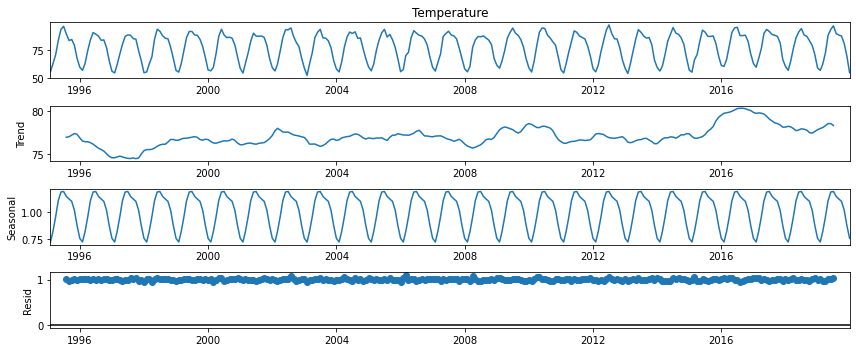

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
result.plot();

**EWMA (Exponentially weighted moving average)**

In [15]:
df2['ewma-12'] = df2['Temperature'].ewm(span=12).mean()

<AxesSubplot:xlabel='Date'>

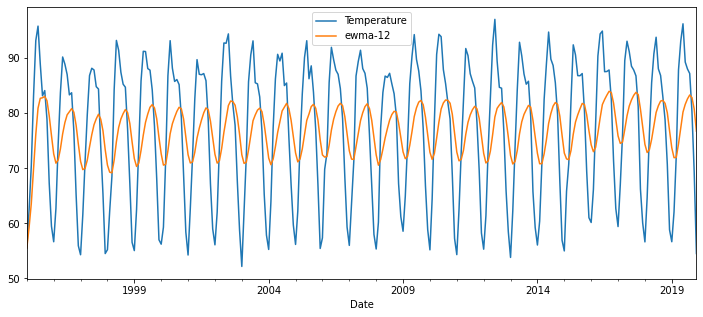

In [16]:
df2[['Temperature','ewma-12']].plot()

**SES : Simple Exponential Smoothing**

In [17]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [18]:
span=12
alpha = 1/(span+1)

In [19]:
df2['EWMA12'] = df2['Temperature'].ewm(alpha=alpha,adjust=False).mean()

In [20]:
model = SimpleExpSmoothing(df2['Temperature'])

/Users/kiran/Desktop/Data_Science_Projects/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [21]:
fitted_model = model.fit(smoothing_level=alpha,optimized=False)

In [24]:
df2['SES12'] = fitted_model.fittedvalues.shift(-1)

<AxesSubplot:xlabel='Date'>

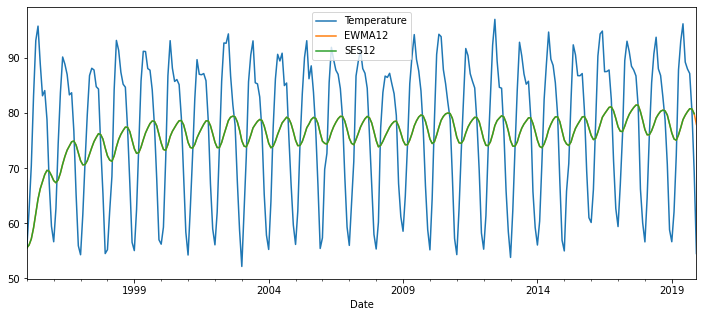

In [25]:
df2[['Temperature','EWMA12','SES12']].plot()

**DES : Double Exponential Smoothing** (adding the trend component)

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
df2['DES_add_12'] = ExponentialSmoothing(df2['Temperature'],trend='add').fit().fittedvalues.shift(-1)

/Users/kiran/Desktop/Data_Science_Projects/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [28]:
df2['DES_mul_12'] = ExponentialSmoothing(df2['Temperature'],trend='mul').fit().fittedvalues.shift(-1)

<AxesSubplot:xlabel='Date'>

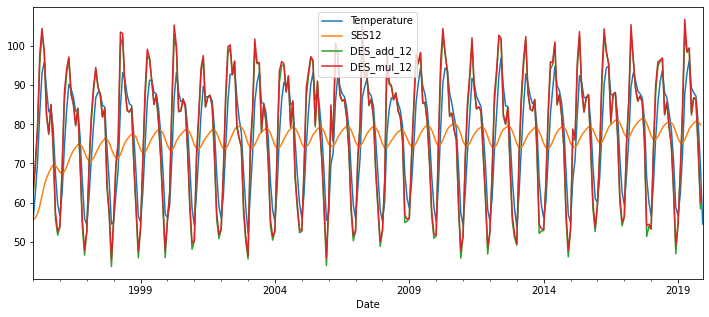

In [29]:
df2[['Temperature','SES12','DES_add_12','DES_mul_12']].plot()

<AxesSubplot:xlabel='Date'>

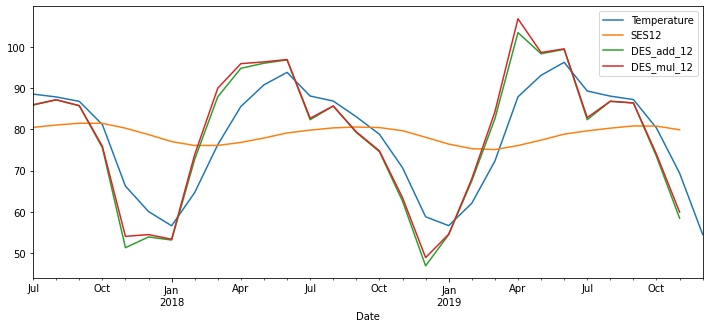

In [30]:
df2[['Temperature','SES12','DES_add_12','DES_mul_12']][270:].plot()

The DES_mul_12 model seems to be right on top of our data.

**TES : Triple Exponential Smoothing** (Adding the seasonal component now)

In [31]:
df2['TES_mul_12'] = ExponentialSmoothing(df2['Temperature'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

/Users/kiran/Desktop/Data_Science_Projects/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/kiran/Desktop/Data_Science_Projects/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning:

overflow encountered in matmul



<AxesSubplot:xlabel='Date'>

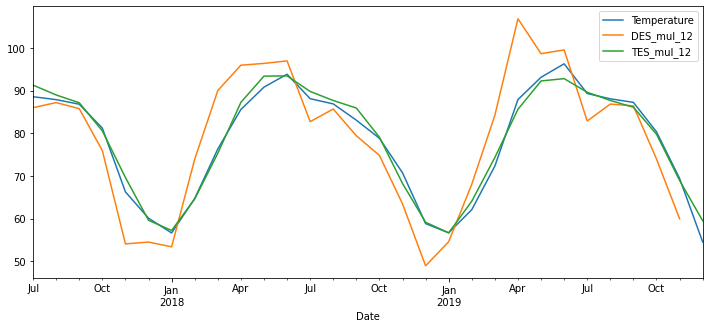

In [32]:
df2[['Temperature','DES_mul_12','TES_mul_12']][270:].plot()

The DES_mul_12 model still seems to be a much better fit for our data.

**ARIMA (Auto-Regressive Integrated Moving Average) model fitting**

In [33]:
from pmdarima import auto_arima

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
# right now we are not concerned with test, train split
stepwise_fit = auto_arima(df2['Temperature'], start_p=0, start_q=0, max_p=6, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3467.806, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3075.975, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1910.135, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1855.012, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1877.656, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1831.170, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1843.029, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1648.144, Time=0.52 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.04 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1803.988, Time=0.71 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1827.154, Time=0.36 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1716.715, Time=0.73 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, T

In [36]:
stepwise_fit.summary() # gives us information about the best ARIMA model found by the fit 
                       # and the corres. Likelihood, AIC scores etc.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -818.072
Date:                Tue, 02 Mar 2021   AIC                           1648.144
Time:                        16:55:14   BIC                           1670.366
Sample:                             0   HQIC                          1657.037
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7031      0.014    197.333      0.000       2.676       2.730
ar.L2         -2.6795      0.026   -102.639      0.000      -2.731      -2.628
ar.L3          0.9764      0.013     72.515      0.000       0.950       1.003
ma.L1         -1.8471      0.028    -65.884      0.000      -1.902      -1.792
ma.L2          0.9025      0.028     32.224      0.000       0.848       0.957
sigma2        13.0720      1.273     10.271      0.000      10.578      15.566
===================================================================================
Ljung-Box (L1) (Q):                  14.27   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.20   Skew:                             0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

and now with seasonality=True

In [37]:
stepwise_fit = auto_arima(df2['Temperature'], start_p=0, start_q=0, 
                          max_p=4, max_q=4, seasonal=True, trace=True, m=12)
# m is the number of periods in a season; 4 for quarterly data, 12 for monthly data, 365 for daily data etc.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1459.574, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2374.882, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1902.424, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3467.806, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2093.096, Time=0.21 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1677.112, Time=2.50 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1917.900, Time=0.70 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1346.093, Time=0.92 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1845.024, Time=0.35 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1

In [38]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -668.046
Date:                              Tue, 02 Mar 2021   AIC                           1346.093
Time:                                      16:56:19   BIC                           1364.612
Sample:                                           0   HQIC                          1353.504
                                              - 300                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3493      0.177      1.978      0.048       0.003       0.695
ar.L1          0.4246      0.052      8.102      0.000       0.322       0.527
ar.S.L12       0.9920      0.004    248.834      0.000       0.984       1.000
ma.S.L12      -0.6805      0.068     -9.996      0.000      -0.814      -0.547
sigma2         4.8999      0.487     10.070      0.000       3.946       5.854
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.64
Prob(Q):                              1.00   Prob(JB):                         0.44
Heteroskedasticity (H):               0.89   Skew:                             0.06
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Getting the orders from augmented Dickey-Fuller test and ACF and PACF plots**

In [39]:
#from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [40]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [41]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [42]:
adf_test(df2['Temperature'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.220950
p-value                   0.198730
# lags used              11.000000
# observations          288.000000
critical value (1%)      -3.453262
critical value (5%)      -2.871628
critical value (10%)     -2.572146
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [43]:
from statsmodels.tsa.statespace.tools import diff

In [44]:
df2['Diff_1'] = diff(df2['Temperature'],k_diff=1)

In [45]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.764279e+01
p-value                 3.751965e-30
# lags used             1.000000e+01
# observations          2.880000e+02
critical value (1%)    -3.453262e+00
critical value (5%)    -2.871628e+00
critical value (10%)   -2.572146e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


So, augmented Dickey-Fuller test confirms that after taking time step 1, the data is stationary.

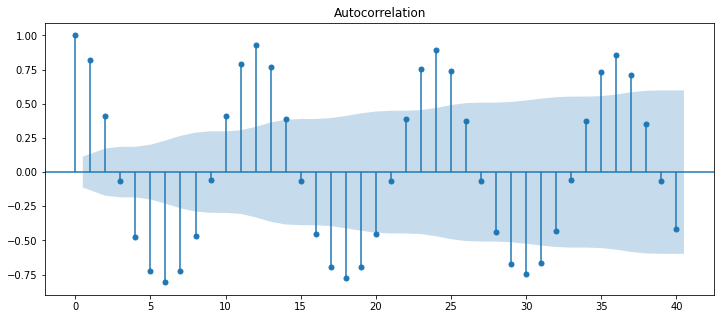

In [46]:
plot_acf(df2['Temperature'],lags=40);

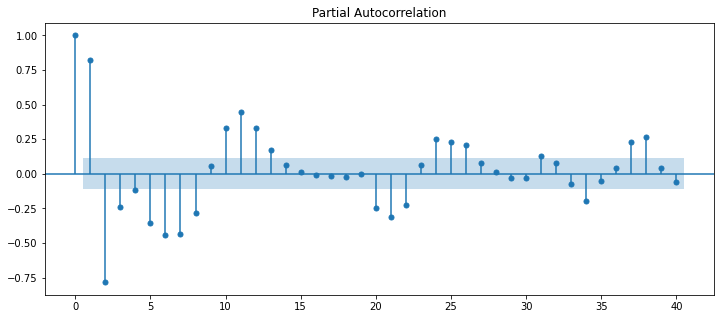

In [47]:
plot_pacf(df2['Temperature'],lags=40);

from Duke university notes :
    Rule 6: If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms.
    
Since PACF cuts off sharply at lag=1, therefore, AR order p =1 seems to be good choice.

from Duke university notes : If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.

Thus classical method would suggest MA order q=0 as a good choice.

In [48]:
auto_arima(df2['Temperature'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -818.072
Date:                Tue, 02 Mar 2021   AIC                           1648.144
Time:                        16:57:41   BIC                           1670.366
Sample:                             0   HQIC                          1657.037
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7031      0.014    197.333      0.000       2.676       2.730
ar.L2         -2.6795      0.026   -102.639      0.000      -2.731      -2.628
ar.L3          0.9764      0.013     72.515      0.000       0.950       1.003
ma.L1         -1.8471      0.028    -65.884      0.000      -1.902      -1.792
ma.L2          0.9025      0.028     32.224      0.000       0.848       0.957
sigma2        13.0720      1.273     10.271      0.000      10.578      15.566
===================================================================================
Ljung-Box (L1) (Q):                  14.27   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.20   Skew:                             0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
train = df2.iloc[:250]
test = df2.iloc[250:]

In [51]:
model = ARMA(train['Temperature'],order=(3,2))

In [52]:
results = model.fit()

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Temperature   No. Observations:                  250
Model:                     ARMA(3, 2)   Log Likelihood                -664.656
Method:                       css-mle   S.D. of innovations              3.421
Date:                Tue, 02 Mar 2021   AIC                           1343.312
Time:                        16:58:01   BIC                           1367.962
Sample:                    01-31-1995   HQIC                          1353.233
                         - 10-31-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                76.6706      0.150    511.442      0.000      76.377      76.964
ar.L1.Temperature     1.6739      0.156     10.698      0.000       1.367       1.981
ar.L2.Temperature    -0.9487      0.265     -3.586      0.000      -1.467      -0.430
ar.L3.Temperature     0.0031      0.152      0.021      0.984      -0.295       0.301
ma.L1.Temperature    -0.5803      0.143     -4.048      0.000      -0.861      -0.299
ma.L2.Temperature    -0.2364      0.116     -2.045      0.041      -0.463      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8856           -0.5253j            1.0297           -0.0852
AR.2            0.8856           +0.5253j            1.0297            0.0852
AR.3          301.4775           -0.0000j          301.4775           -0.0000
MA.1            1.1677           +0.0000j            1.1677            0.0000
MA.2           -3.6225           +0.0000j            3.6225            0.5000
-----------------------------------------------------------------------------
"""

In [54]:
start = len(train); end = start  + len(test) - 1
predictions = results.predict(start,end).rename('ARMA (3,2) predictions')

<AxesSubplot:xlabel='Date'>

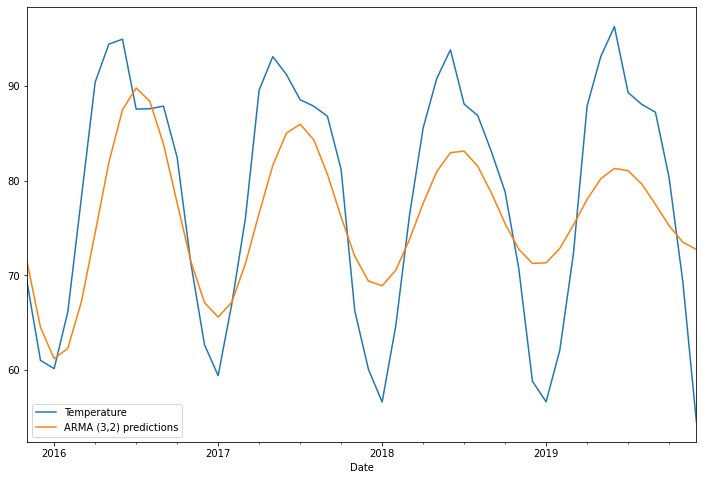

In [55]:
test['Temperature'].plot(figsize=(12,8),legend=True)
predictions.plot(legend=True)

In [56]:
test["Temperature"].mean(),predictions.mean()

(78.25392247470735, 76.02320234708803)

The bad fit is because we ignored the very strong seasonal component in the data.\
Let's use auto\_arima again, this time with seasonal=True

In [57]:
auto_arima(df2['Temperature'],seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -668.046
Date:                              Tue, 02 Mar 2021   AIC                           1346.093
Time:                                      16:58:59   BIC                           1364.612
Sample:                                           0   HQIC                          1353.504
                                              - 300                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3493      0.177      1.978      0.048       0.003       0.695
ar.L1          0.4246      0.052      8.102      0.000       0.322       0.527
ar.S.L12       0.9920      0.004    248.834      0.000       0.984       1.000
ma.S.L12      -0.6805      0.068     -9.996      0.000      -0.814      -0.547
sigma2         4.8999      0.487     10.070      0.000       3.946       5.854
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.64
Prob(Q):                              1.00   Prob(JB):                         0.44
Heteroskedasticity (H):               0.89   Skew:                             0.06
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [59]:
model = SARIMAX(train['Temperature'],order=(1,0,0),seasonal_order=(1,0,1,12))

In [60]:
results = model.fit()

In [61]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Temperature   No. Observations:                  250
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -577.436
Date:                              Tue, 02 Mar 2021   AIC                           1162.873
Time:                                      16:59:12   BIC                           1176.959
Sample:                                  01-31-1995   HQIC                          1168.542
                                       - 10-31-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5057      0.053      9.569      0.000       0.402       0.609
ar.S.L12       0.9997      0.000   5769.997      0.000       0.999       1.000
ma.S.L12      -0.7136      0.070    -10.142      0.000      -0.852      -0.576
sigma2         4.5007      0.450      9.997      0.000       3.618       5.383
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.22   Prob(JB):                         0.84
Heteroskedasticity (H):               0.87   Skew:                             0.09
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
# making predictions
train_predictions = results.predict(0,len(train)-1,typ='levels').rename('SARIMA train Predictions')
start = len(train); end=start+len(test)-1
test_predictions = results.predict(start,end,typ='levels').rename('SARIMA test Predictions')

<AxesSubplot:xlabel='Date'>

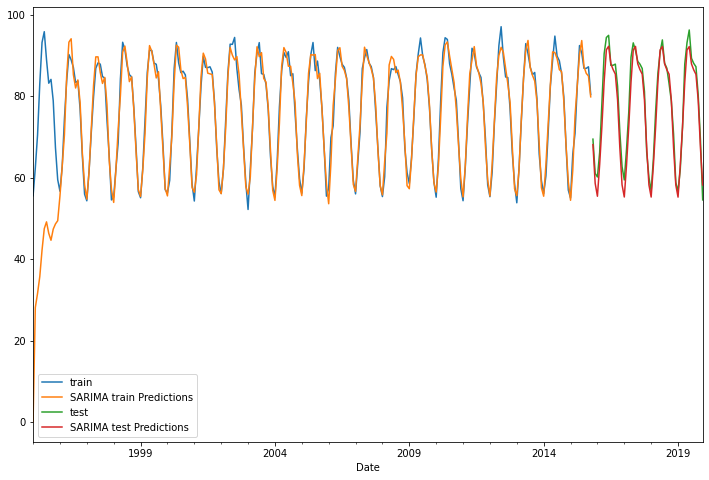

In [63]:
train['Temperature'].plot(figsize=(12,8), label='train', legend=True)
train_predictions.plot(legend=True)
test['Temperature'].plot(label='test',legend=True)
test_predictions.plot(legend=True)

### Evaluating predictions

In [64]:
from statsmodels.tools.eval_measures import rmse

In [65]:
error = rmse(test['Temperature'],test_predictions)
error

2.832873107091561

In [66]:
error/test['Temperature'].mean()

0.03620103654238139

### forecasting into the unknown future

In [67]:
model = SARIMAX(df2['Temperature'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Temperature   No. Observations:                  300
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -37.143
Date:                              Tue, 02 Mar 2021   AIC                             82.287
Time:                                      17:00:01   BIC                             97.102
Sample:                                  01-31-1995   HQIC                            88.216
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999   8.32e-09   -1.2e+08      0.000      -1.000      -1.000
ar.S.L12       0.9999   1.09e-08   9.14e+07      0.000       1.000       1.000
ma.S.L12       0.9985   1.49e-07   6.68e+06      0.000       0.999       0.999
sigma2        15.2352   2.84e-06   5.37e+06      0.000      15.235      15.235
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            243234.53
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            11.39
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
fcast = results.predict(start=len(df2),end=len(df2)+11,typ='levels').rename('SARIMA Forecast')

<AxesSubplot:xlabel='Date'>

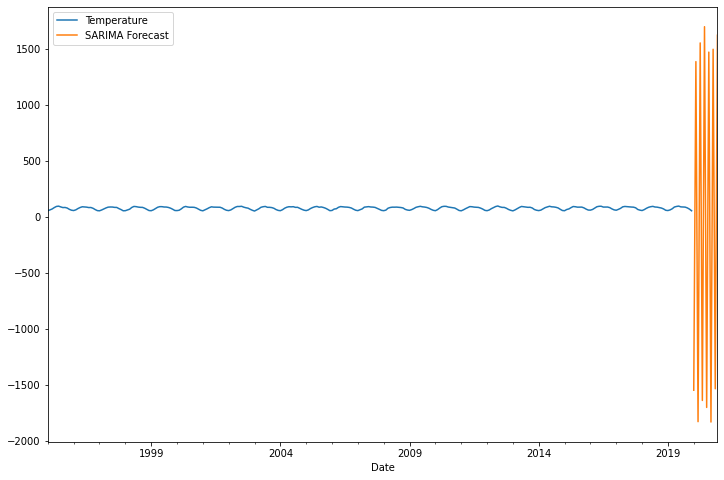

In [69]:
df2['Temperature'].plot(figsize=(12,8),legend=True)
fcast.plot(legend=True)

Trying the best-fit model obtained from R i.e. 1,1,1,0,1,1,12

In [70]:
model = SARIMAX(df2['Temperature'],order=(1,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -606.999
Date:                            Tue, 02 Mar 2021   AIC                           1221.998
Time:                                    17:01:36   BIC                           1236.635
Sample:                                01-31-1995   HQIC                          1227.864
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3468      0.056      6.139      0.000       0.236       0.458
ma.L1         -0.9998      1.433     -0.698      0.485      -3.809       1.809
ma.S.L12      -0.9997     16.502     -0.061      0.952     -33.342      31.343
sigma2         3.4102     56.562      0.060      0.952    -107.449     114.269
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.84   Prob(JB):                         0.54
Heteroskedasticity (H):               1.15   Skew:                             0.13
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

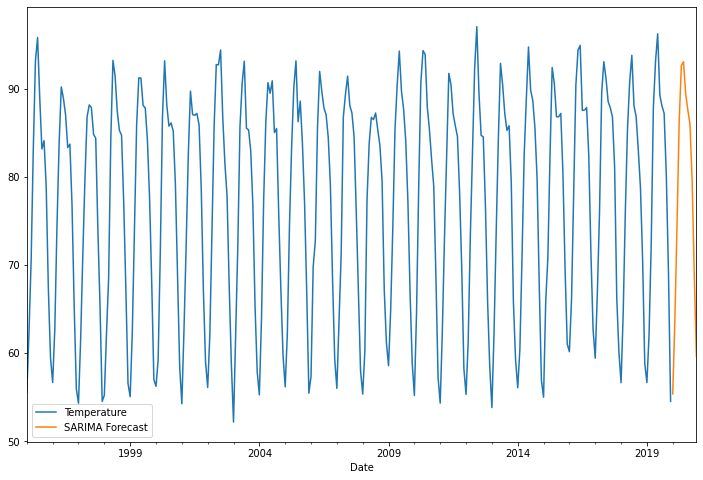

In [71]:
fcast = results.predict(start=len(df2),end=len(df2)+11,typ='levels').rename('SARIMA Forecast')

df2['Temperature'].plot(figsize=(12,8),legend=True)
fcast.plot(legend=True)